# Analyze zoning districts and minimum lot sizes

In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DB = create_engine('postgresql://jon@localhost:5432/propertydb')

In [3]:
ZONES = pd.DataFrame([
    ['R1D-VL', 8000, 'SINGLE|TOWNHOUSE|ROWHOUSE'],
    ['R1D-L', 5000, 'SINGLE|TOWNHOUSE|ROWHOUSE'],
    ['R1D-M', 3200, 'SINGLE|TOWNHOUSE|ROWHOUSE'], # 'R1A-M'
    ['R1D-H', 1800, 'SINGLE|TOWNHOUSE|ROWHOUSE'], # 'R1A-H'
    ['R1D-VH', 1200, 'SINGLE|TOWNHOUSE|ROWHOUSE'], # 'R1A-VH'
    ['RM-VL', 8000*4, 'APART|FOUR'],
    ['RM-L', 3000*4, 'APART|FOUR'],
    ['RM-M', 1800*4, 'APART|FOUR'],
    ['RM-H', 750*4, 'APART|FOUR'],
    ['RM-VH', 400*4, 'APART|FOUR']
], columns=['zon_new', 'minlot4construction', 'usedesc'])

In [4]:
def gen_lot_size_hist(zones):
    zon_new_parcels = parcels[parcels.zon_new.isin(zones)]

    zon_new_info = ZONES[ZONES.zon_new == zones[0]]
    zon_new_parcels_constructed = zon_new_parcels[zon_new_parcels.usedesc.str.contains(zon_new_info.usedesc.values[0])]
    zon_new_parcels_min = zon_new_info.minlot4construction.values[0]

    # Print quick stats
    zon_new_parcels_below_len = len(zon_new_parcels[zon_new_parcels.lotarea <= zon_new_parcels_min])
    zon_new_parcels_len = len(zon_new_parcels)

    print('Below: %s (%s)' % (zon_new_parcels_below_len, round(zon_new_parcels_below_len / zon_new_parcels_len, 2)))
    print('At/above: %s (%s)' % (zon_new_parcels_len - zon_new_parcels_below_len, round((zon_new_parcels_len - zon_new_parcels_below_len) / len(zon_new_parcels), 2)))

    # Sketch the plot
    fig, ax = plt.subplots()
    ax.hist([
        zon_new_parcels.lotarea.values.flatten(),
        zon_new_parcels_constructed.lotarea.values.flatten()
    ], bins=30, range=(0, 30000), label=['Parcels', 'Parcels constructed'])

    # zon_new_parcels.plot(kind='hist', column='lotarea', bins=30, range=(400, 30000), label='Parcels')
    # zon_new_parcels[zon_new_parcels.usedesc.str.contains('APART')].plot(kind='hist', column='lotarea', bins=30, range=(400, 30000), label='Apts')

    plt.title("%s MLS (%s sqft)" % (', '.join(zones), zon_new_parcels_min))

    plt.axvline(zon_new_parcels_min, label='MLS for construction', color='red', linestyle='dashed', alpha=0.2)
    plt.axvspan(0, zon_new_parcels_min, label='Parcels below MLS for construction', alpha=0.2, color='red')
    plt.axvline(zon_new_parcels_constructed.lotarea.min(), label='Smallest parcel constructed', color='green', linestyle='dashed', alpha=0.2)
    plt.legend()
    return plt

### Import RM, R1 parcels

In [5]:
parcels = gpd.read_postgis("""SELECT assessments.*, zon_new, parcelboundaries.geom
FROM assessments
JOIN parcelboundaries
ON parcelboundaries.parcelid = assessments.parcelid
JOIN parcelzoningpgh
ON ST_WITHIN(parcelboundaries.geom, parcelzoningpgh.geom)
WHERE municode::int < 200
AND lotarea::int > 1
AND LEFT(zon_new, 2) IN ('RM', 'R1')
AND usedesc NOT IN ('CONDOMINIUM', 'CONDO DEVELOPMENTAL LAND', 'CONDO GARAGE UNITS');""", DB, crs='EPSG:4326')

In [6]:
parcels['lotarea'] = parcels.lotarea.astype(int)

### Parcel count by RM density

In [7]:
parcels[parcels.zon_new.str.startswith('RM')].zon_new.value_counts()

zon_new
RM-M     8159
RM-H      227
RM-VH     108
RM-VL       8
Name: count, dtype: int64

### Lot size histograms for RM densities

Below: 7405 (0.91)
At/above: 754 (0.09)


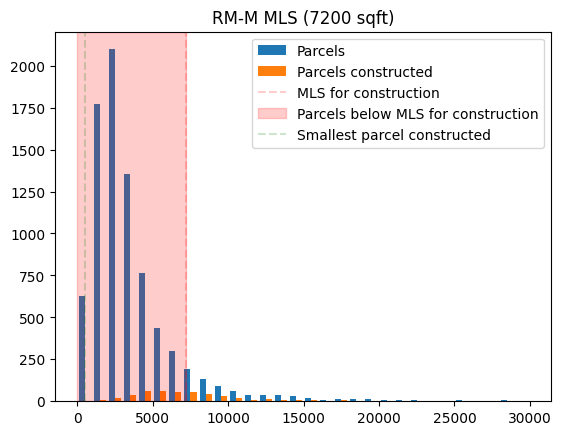

In [8]:
gen_lot_size_hist(['RM-M']).show()

Below: 82 (0.36)
At/above: 145 (0.64)


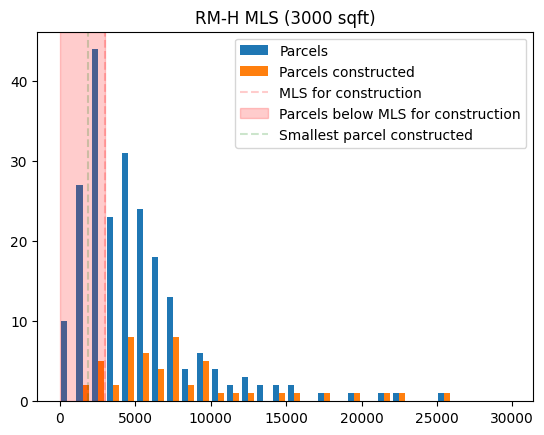

In [9]:
gen_lot_size_hist(['RM-H']).show()

Below: 2 (0.02)
At/above: 106 (0.98)


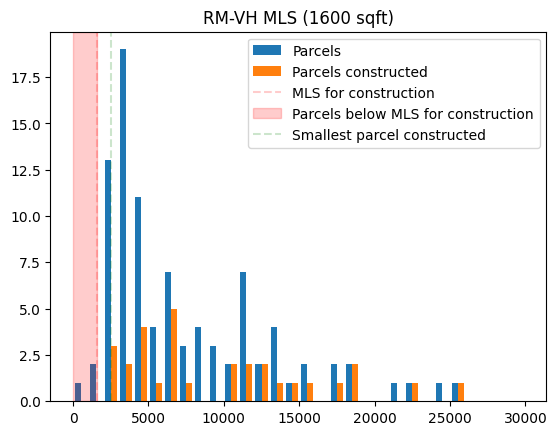

In [10]:
gen_lot_size_hist(['RM-VH']).show()

### Parcel count by R1 density

In [11]:
parcels[parcels.zon_new.str.startswith('R1')].zon_new.value_counts()

zon_new
R1D-H     19281
R1D-L     17962
R1D-M     13705
R1A-VH     9450
R1A-H      7741
R1D-VL     1315
R1A-M       908
R1D-VH       46
Name: count, dtype: int64

### Lot size histograms for R1 densities

Below: 491 (0.37)
At/above: 824 (0.63)


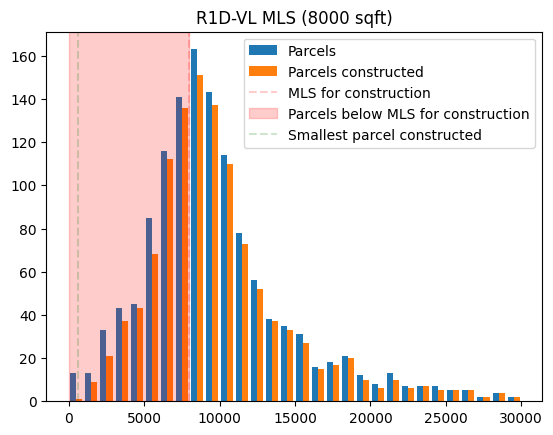

In [12]:
gen_lot_size_hist(['R1D-VL']).show()

Below: 8042 (0.45)
At/above: 9920 (0.55)


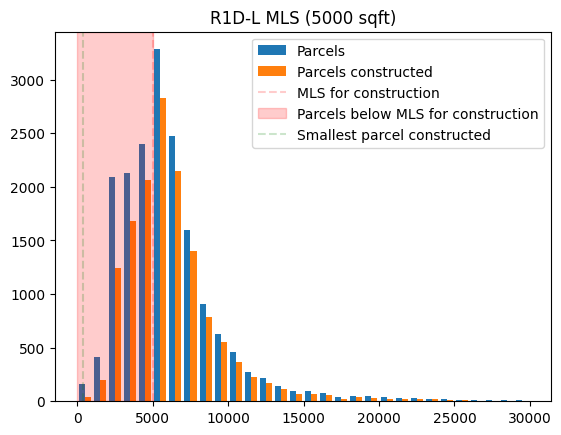

In [13]:
gen_lot_size_hist(['R1D-L']).show()

Below: 3503 (0.24)
At/above: 11110 (0.76)


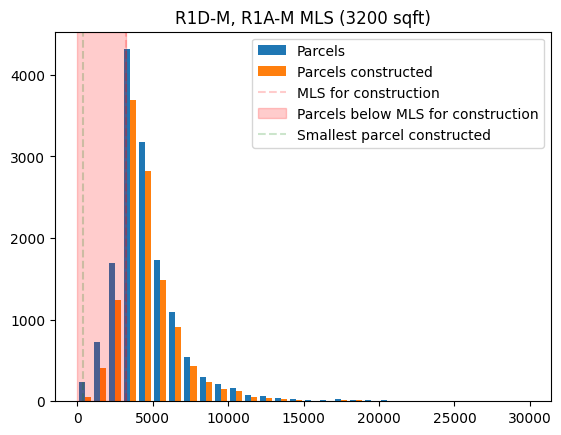

In [14]:
gen_lot_size_hist(['R1D-M', 'R1A-M']).show()

Below: 4554 (0.17)
At/above: 22468 (0.83)


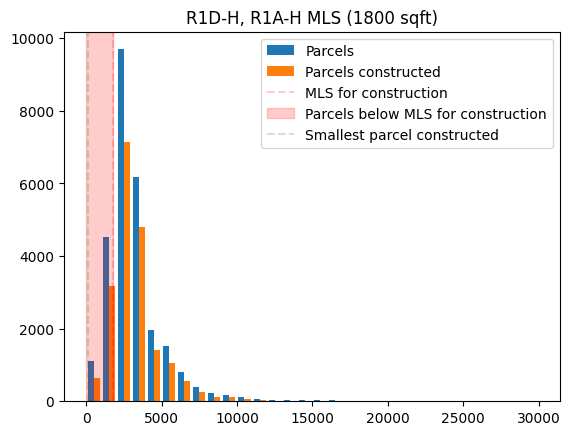

In [15]:
gen_lot_size_hist(['R1D-H', 'R1A-H']).show()

Below: 3334 (0.35)
At/above: 6162 (0.65)


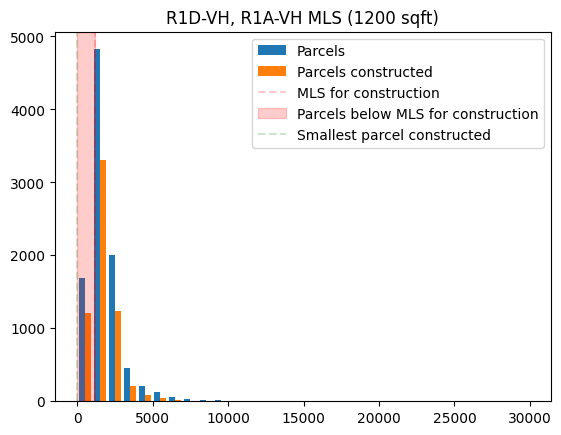

In [16]:
gen_lot_size_hist(['R1D-VH', 'R1A-VH']).show()

### Calculate `RM-M` impact of keeping min lot size, removing per-unit min lot size

In [18]:
rmm = parcels[
    (parcels.zon_new == 'RM-M') &
    (~parcels.usedesc.str.contains('APART|FOUR')) &
    (parcels.lotarea >= 3200) &
    (parcels.lotarea < 7200)
]

rmm_sum = rmm.munidesc.value_counts().reset_index().rename(columns={'count': 'countLot'})
rmm_sum['count4Apt'] = rmm_sum.countLot * 4

print([rmm_sum.countLot.sum(), rmm_sum.count4Apt.sum()])
rmm_sum

[2207, 8828]


,munidesc,countLot,count4Apt
0,13th Ward - PITTSBURGH,644,2576
1,14th Ward - PITTSBURGH,528,2112
2,12th Ward - PITTSBURGH,459,1836
3,5th Ward - PITTSBURGH,227,908
4,3rd Ward - PITTSBURGH,64,256
5,7th Ward - PITTSBURGH,62,248
6,21st Ward - PITTSBURGH,50,200
7,15th Ward - PITTSBURGH,37,148
8,19th Ward - PITTSBURGH,20,80
9,11th Ward - PITTSBURGH,19,76
